# Quantum-Assisted RBM training on the BAS Dataset for Reconstruction
This is an example on quantum-assisted training of an RBM on the BAS(4,4)
dataset.
Developed by: Jose Pinilla

In [1]:
# Required packages
import qaml
import torch
torch.manual_seed(0) # For deterministic weights

import matplotlib.pyplot as plt
import torchvision.transforms as torch_transforms


In [2]:
################################# Hyperparameters ##############################
M,N = SHAPE = (4,4)
DATA_SIZE = N*M
HIDDEN_SIZE = 16
EPOCHS = 500
SAMPLES = 1000
BATCH_SIZE = 500
# Stochastic Gradient Descent
learning_rate = 0.1
weight_decay = 1e-4
momentum = 0.5


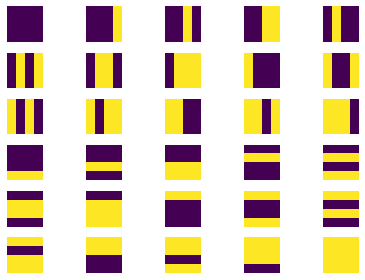

In [3]:
#################################### Input Data ################################
train_dataset = qaml.datasets.BAS(*SHAPE,transform=torch_transforms.ToTensor())
train_sampler = torch.utils.data.RandomSampler(train_dataset,replacement=True,
                                               num_samples=SAMPLES)
train_loader = torch.utils.data.DataLoader(train_dataset,sampler=train_sampler,
                                           batch_size=BATCH_SIZE)

# PLot all data
fig,axs = plt.subplots(6,5)
for ax,(img,label) in zip(axs.flat,train_dataset):
    ax.matshow(img.view(*SHAPE),vmin=0,vmax=1); ax.axis('off')
plt.tight_layout()


In [4]:
################################# Model Definition #############################
# Specify model with dimensions
rbm = qaml.nn.RBM(DATA_SIZE,HIDDEN_SIZE)

# Initialize biases
torch.nn.init.constant_(rbm.b,0.5)
torch.nn.init.zeros_(rbm.c)
torch.nn.init.uniform_(rbm.W,-0.5,0.5)

# Set up optimizers
optimizer = torch.optim.SGD(rbm.parameters(), lr=learning_rate,
                            weight_decay=weight_decay,momentum=momentum)

# Set up training mechanisms
solver_name = "Advantage_system1.1"
qa_sampler = qaml.sampler.QASampler(rbm,solver=solver_name,beta=2.5)

# Loss and autograd
CD = qaml.autograd.SampleBasedConstrastiveDivergence()


In [5]:
################################## Model Training ##############################
# Set the model to training mode
rbm.train()
err_log = []
b_log = [rbm.b.detach().clone().numpy()]
c_log = [rbm.c.detach().clone().numpy()]
W_log = [rbm.W.detach().clone().numpy().flatten()]
for t in range(EPOCHS):
    epoch_error = torch.Tensor([0.])

    for img_batch, labels_batch in train_loader:
        input_data = img_batch.flatten(1)

        # Positive Phase
        v0, prob_h0 = input_data, rbm(input_data)
        # Negative Phase
        vk, prob_hk = qa_sampler(BATCH_SIZE,auto_scale=False)

        # Reconstruction error from Contrastive Divergence
        err = CD.apply((v0,prob_h0), (vk,prob_hk), *rbm.parameters())

        # Do not accumulate gradients
        optimizer.zero_grad()

        # Compute gradients
        err.backward()

        # Update parameters
        optimizer.step()

        #Accumulate error for this epoch
        epoch_error  += err

    # Error Log
    b_log.append(rbm.b.detach().clone().numpy())
    c_log.append(rbm.c.detach().clone().numpy())
    W_log.append(rbm.W.detach().clone().numpy().flatten())
    err_log.append(epoch_error.item())
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")

# Set the model to evaluation mode
# rbm.eval()


Epoch 0 Reconstruction Error = 6.584000110626221
Epoch 1 Reconstruction Error = 4.235999584197998
Epoch 2 Reconstruction Error = 2.1059999465942383
Epoch 3 Reconstruction Error = 2.1359996795654297
Epoch 4 Reconstruction Error = 1.8539998531341553
Epoch 5 Reconstruction Error = 1.8019999265670776
Epoch 6 Reconstruction Error = 1.8959999084472656
Epoch 7 Reconstruction Error = 1.6059999465942383
Epoch 8 Reconstruction Error = 1.908000111579895
Epoch 9 Reconstruction Error = 1.656000018119812
Epoch 10 Reconstruction Error = 1.431999921798706
Epoch 11 Reconstruction Error = 1.8500001430511475
Epoch 12 Reconstruction Error = 1.7160001993179321
Epoch 13 Reconstruction Error = 1.9560000896453857
Epoch 14 Reconstruction Error = 1.5279998779296875
Epoch 15 Reconstruction Error = 1.7319998741149902
Epoch 16 Reconstruction Error = 2.1600000858306885
Epoch 17 Reconstruction Error = 1.7080001831054688
Epoch 18 Reconstruction Error = 1.9380000829696655
Epoch 19 Reconstruction Error = 1.844000101089

Epoch 161 Reconstruction Error = 2.128000259399414
Epoch 162 Reconstruction Error = 1.948000192642212
Epoch 163 Reconstruction Error = 1.7439998388290405
Epoch 164 Reconstruction Error = 1.0739998817443848
Epoch 165 Reconstruction Error = 1.6780002117156982
Epoch 166 Reconstruction Error = 1.6540000438690186
Epoch 167 Reconstruction Error = 1.9020001888275146
Epoch 168 Reconstruction Error = 1.7180001735687256
Epoch 169 Reconstruction Error = 1.9380000829696655
Epoch 170 Reconstruction Error = 1.503999948501587
Epoch 171 Reconstruction Error = 1.8659999370574951
Epoch 172 Reconstruction Error = 1.5740001201629639
Epoch 173 Reconstruction Error = 1.1119999885559082
Epoch 174 Reconstruction Error = 2.063999891281128
Epoch 175 Reconstruction Error = 1.371999979019165
Epoch 176 Reconstruction Error = 1.6319999694824219
Epoch 177 Reconstruction Error = 1.8599998950958252
Epoch 178 Reconstruction Error = 1.7420001029968262
Epoch 179 Reconstruction Error = 1.3179997205734253
Epoch 180 Reconst

Epoch 320 Reconstruction Error = 1.715999722480774
Epoch 321 Reconstruction Error = 1.741999864578247
Epoch 322 Reconstruction Error = 1.4180001020431519
Epoch 323 Reconstruction Error = 1.5
Epoch 324 Reconstruction Error = 2.239999771118164
Epoch 325 Reconstruction Error = 1.741999864578247
Epoch 326 Reconstruction Error = 2.0380001068115234
Epoch 327 Reconstruction Error = 1.7140001058578491
Epoch 328 Reconstruction Error = 1.997999906539917
Epoch 329 Reconstruction Error = 1.465999960899353
Epoch 330 Reconstruction Error = 1.5439999103546143
Epoch 331 Reconstruction Error = 1.50600004196167
Epoch 332 Reconstruction Error = 1.7579998970031738
Epoch 333 Reconstruction Error = 2.25
Epoch 334 Reconstruction Error = 1.4679999351501465
Epoch 335 Reconstruction Error = 2.0160000324249268
Epoch 336 Reconstruction Error = 2.058000087738037
Epoch 337 Reconstruction Error = 2.1600003242492676
Epoch 338 Reconstruction Error = 1.5459997653961182
Epoch 339 Reconstruction Error = 1.754000067710876

Epoch 479 Reconstruction Error = 1.5239999294281006
Epoch 480 Reconstruction Error = 1.9119999408721924
Epoch 481 Reconstruction Error = 1.5320000648498535
Epoch 482 Reconstruction Error = 1.7080001831054688
Epoch 483 Reconstruction Error = 1.5540000200271606
Epoch 484 Reconstruction Error = 1.9280000925064087
Epoch 485 Reconstruction Error = 1.5820001363754272
Epoch 486 Reconstruction Error = 2.485999822616577
Epoch 487 Reconstruction Error = 1.9380000829696655
Epoch 488 Reconstruction Error = 1.8980000019073486
Epoch 489 Reconstruction Error = 1.4760000705718994
Epoch 490 Reconstruction Error = 2.4140000343322754
Epoch 491 Reconstruction Error = 1.5800000429153442
Epoch 492 Reconstruction Error = 1.2360000610351562
Epoch 493 Reconstruction Error = 1.337999939918518
Epoch 494 Reconstruction Error = 1.9200000762939453
Epoch 495 Reconstruction Error = 1.6219998598098755
Epoch 496 Reconstruction Error = 1.9100003242492676
Epoch 497 Reconstruction Error = 1.409999966621399
Epoch 498 Recon

qBAS : Precision = 0.2 Recall = 0.8 Score = 0.32


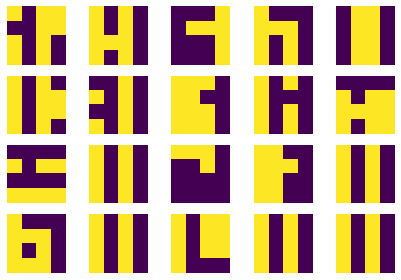

In [6]:
################################# qBAS Score ###################################
num_samples = 1000 # CLASSICAL
gibbs_sampler = qaml.sampler.GibbsNetworkSampler(rbm)
prob_v,_ = gibbs_sampler(torch.rand(num_samples,DATA_SIZE),k=10)
img_samples = prob_v.view(num_samples,*SHAPE).bernoulli()
# PLot some samples
fig,axs = plt.subplots(4,5)
for ax,img in zip(axs.flat,img_samples):
    ax.matshow(img.view(*SHAPE),vmin=0,vmax=1); ax.axis('off')
plt.tight_layout()
# Get and print score
p,r,score = train_dataset.score(img_samples)
print(f"qBAS : Precision = {p:.02} Recall = {r:.02} Score = {score:.02}")


In [7]:
############################## RECONSTRUCTION ##################################
k = 10
count = 0
mask = torch_transforms.functional.erase(torch.ones(1,*SHAPE),1,1,2,2,0).flatten()
for img, label in train_dataset:

    clamped = mask*img.flatten(1)
    prob_hk = rbm.forward(clamped + (1-mask)*0.5)
    prob_vk = rbm.generate(prob_hk).detach()
    for _ in range(k):
        masked = clamped + (1-mask)*prob_vk.data
        prob_hk.data = rbm.forward(masked).data
        prob_vk.data = rbm.generate(prob_hk).data
    recon = (clamped + (1-mask)*prob_vk).bernoulli().view(img.shape)

    if recon.equal(img):
        count+=1
print(f"Dataset Reconstruction: {count/len(train_dataset):.02}")


Dataset Reconstruction: 0.57


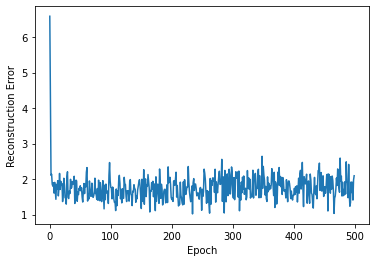

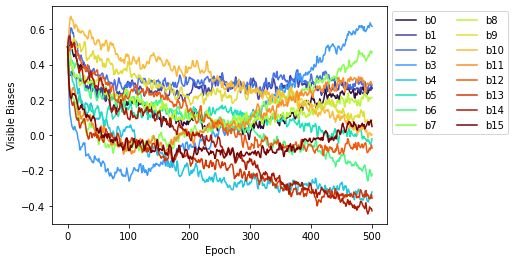

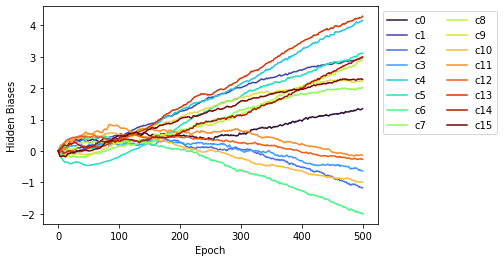

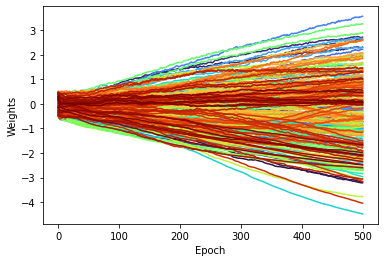

In [8]:
############################ MODEL VISUALIZATION ###############################

# L1 error graph
plt.plot(err_log)
plt.ylabel("Reconstruction Error")
plt.xlabel("Epoch")
plt.savefig("quantum_err_log.pdf")

# Visible bias graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',DATA_SIZE).colors))
lc_v = ax.plot(b_log)
plt.legend(iter(lc_v),[f'b{i}' for i in range(DATA_SIZE)],ncol=2,bbox_to_anchor=(1,1))
plt.ylabel("Visible Biases")
plt.xlabel("Epoch")
plt.savefig("quantum_b_log.pdf")

# Hidden bias graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',HIDDEN_SIZE).colors))
lc_h = plt.plot(c_log)
plt.legend(lc_h,[f'c{i}' for i in range(HIDDEN_SIZE)],ncol=2,bbox_to_anchor=(1,1))
plt.ylabel("Hidden Biases")
plt.xlabel("Epoch")
plt.savefig("quantum_c_log.pdf")

# Weights graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',rbm.V*rbm.H).colors))
lc_w = plt.plot(W_log)
plt.ylabel("Weights")
plt.xlabel("Epoch")
plt.savefig("quantum_W_log.pdf")


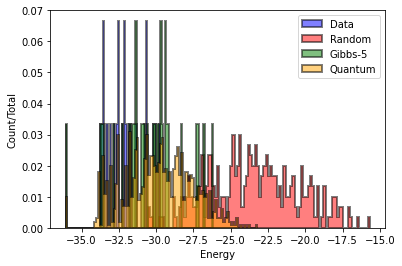

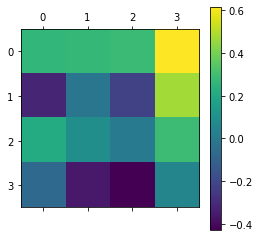

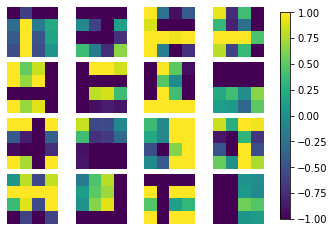

In [9]:
################################## ENERGY ######################################

data_energies = []
for img,label in train_dataset:
    data = img.flatten(1)
    data_energies.append(rbm.free_energy(data).item())

rand_energies = []
rand_data = torch.rand(len(train_dataset)*10,rbm.V)
for img in rand_data:
    rand_energies.append(rbm.free_energy(img.bernoulli()).item())

gibbs_energies = []
gibbs_sampler = qaml.sampler.GibbsNetworkSampler(rbm)
for img,label in train_dataset:
    data = img.flatten(1)
    prob_v,prob_h = gibbs_sampler(data,k=5)
    gibbs_energies.append(rbm.free_energy(prob_v.bernoulli()).item())

qa_energies = []
qa_sampleset = qa_sampler(num_reads=1000,auto_scale=False)
for s_v,s_h in zip(*qa_sampleset):
    qa_energies.append(rbm.free_energy(s_v.detach()).item())

plot_data = [(data_energies,  'Data',    'blue'),
             (rand_energies,  'Random',  'red'),
             (gibbs_energies, 'Gibbs-5', 'green'),
             (qa_energies,    'Quantum', 'orange')]

hist_kwargs = {'ec':'k','lw':2.0,'alpha':0.5,'histtype':'stepfilled','bins':100}
weights = lambda data: [1./len(data) for _ in data]

for data,name,color in plot_data:
    plt.hist(data,weights=weights(data),label=name,color=color,**hist_kwargs)

plt.xlabel("Energy")
plt.ylabel("Count/Total")
plt.legend(loc='upper right')
plt.savefig("quantum_energies.pdf")

################################## VISUALIZE ###################################
plt.matshow(rbm.b.detach().view(*SHAPE), cmap='viridis')
plt.colorbar()

fig,axs = plt.subplots(HIDDEN_SIZE//4,4)
for i,ax in enumerate(axs.flat):
    weight_matrix = rbm.W[i].detach().view(*SHAPE)
    ms = ax.matshow(weight_matrix, cmap='viridis', vmin=-1, vmax=1)
    ax.axis('off')
fig.subplots_adjust(wspace=0.1, hspace=0.1)
cbar = fig.colorbar(ms, ax=axs.ravel().tolist(), shrink=0.95)
plt.savefig("quantum_weights.pdf")